TODO:
- Remove overplotting for reviewer 1

In [1]:
import numpy as np
import pandas as pd
import os

from lib.plotting import *
from lib.preferences import *

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches
import seaborn as sns

import matplotlib.gridspec as gridspec

# inline stylization
%matplotlib inline
sns.set_style("ticks")
sns.set_style('white')
#sns.set_style("ticks")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

## Settings

In [3]:
savefig = True
output_dir = "../figs/review"

## Load summary tables

In [4]:
br_df = pd.read_csv("../summary_tables/2021-02-01_corr-bite_rate_per_v.csv")
gamma_df = pd.read_csv("../summary_tables/2021-02-01_corr-gamma.csv")
nv_df = pd.read_csv("../summary_tables/2021-02-01_corr-nv.csv")

In [5]:
# Restrict to equilibrium epoch
br_df = br_df.query("epoch == 'InitVar'")
gamma_df = gamma_df.query("epoch == 'InitVar'")
nv_df = nv_df.query("epoch == 'InitVar'")

# Remove E[X_h] <= 0.2; as there is considerable extinction here
# br_df = br_df.query("HX_expected > 0.11")
# gamma_df = gamma_df.query("HX_expected > 0.11")
# nv_df = nv_df.query("HX_expected > 0.11")

## Summarize regression results

In [6]:
def create_ols_summary(x_h, genetic_metrics, df):
    """
    Create a table summarize OLS results for every
    statistic in `genetic_metrics` against `x_h`
    
    """

    stats = ["metric", "mu", "r2", "slope", "conf_down", "conf_up"]
    dt_ols = {}
    for stat in stats:
        dt_ols[stat] = []

    for metric in genetic_metrics:
        # Fit Model
        ols = smf.ols(metric + "~" + x_h, df).fit()

        # Statistics
        r2 = ols.rsquared
        slope = ols.params[x_h]
        conf_down, conf_up = ols.conf_int().loc[x_h]
        mu = df[metric].mean()

        # Storage
        dt_ols["metric"].append(metric)
        dt_ols["mu"].append(mu)
        dt_ols["r2"].append(r2)
        dt_ols["slope"].append(slope)
        dt_ols["conf_down"].append(conf_down)
        dt_ols["conf_up"].append(conf_up)

    return pd.DataFrame(dt_ols)[stats]

In [7]:
genetic_metrics = tight_metrics

In [8]:
br_ols = create_ols_summary(x_h="HX_expected", 
                            genetic_metrics=tight_metrics,
                            df=br_df)

In [9]:
gamma_ols = create_ols_summary(x_h="HX_expected", 
                               genetic_metrics=tight_metrics,
                               df=gamma_df)

In [10]:
nv_ols = create_ols_summary(x_h="HX_expected", 
                            genetic_metrics=tight_metrics,
                            df=nv_df)

/anaconda2/envs/dream/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1666: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


## Munge to assist plotting
- Limit to tight_metrics
- Sort by tight_metrics
- Add an "index" column
- Add a "intervention" column
- Add a "color" column
- Merge for all data sets
- Compute a "mean normalized slope"

In [11]:
def get_metric_ix(metric, tight_metrics):
    return [j for j, m in enumerate(tight_metrics[::-1]) if m == metric][0]

In [12]:
def munge_df(df, intervention, col, tight_metrics):
    df = df.copy()
    df.query("metric in @tight_metrics", inplace=True)
    df.insert(0, "ix", [get_metric_ix(metric, tight_metrics) for metric in df["metric"]])
    df.sort_values("ix", inplace=True)
    df["intervention"] = intervention
    df["color"] = [col]*len(df)
    return df

In [13]:
g = munge_df(gamma_ols, 
             intervention="gamma", 
             col=sns.color_palette("Blues", 6)[4], 
             tight_metrics=tight_metrics)

In [14]:
b = munge_df(br_ols, 
             intervention="br", 
             col=sns.color_palette("Greens", 6)[4], 
             tight_metrics=tight_metrics)

In [15]:
n = munge_df(nv_ols, 
             intervention="nv", 
             col=sns.color_palette("Reds", 6)[4], 
             tight_metrics=tight_metrics)

In [16]:
final_df = pd.concat([g, b, n])

## Plot $r^2$ across interventions

## Wide

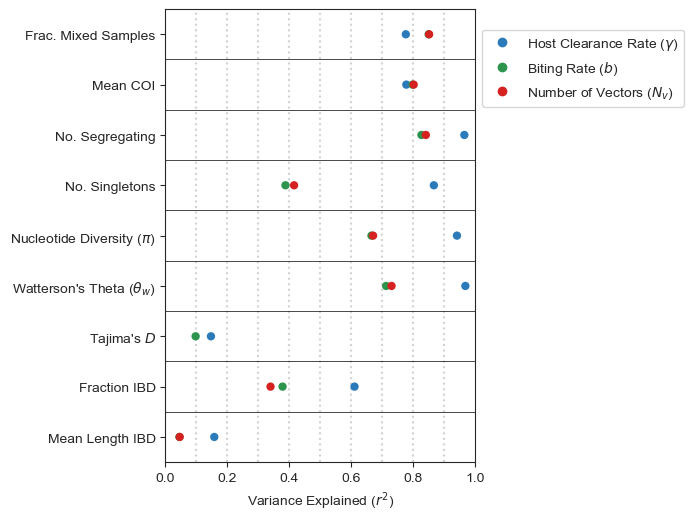

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))

ax.scatter(final_df["r2"], 
           final_df["ix"],
           color=final_df["color"],
           marker="o",
           linewidth=0)

# Limits
ax.set_ylim((-0.5, len(tight_metrics) - 0.5))
ax.set_xlim((0, 1.0))

# Ticks
ax.set_yticks(np.arange(0, len(tight_metrics)))
ax.set_yticklabels([genetic_names[m] for m in tight_metrics[::-1]])

# Lines
for i in np.arange(len(tight_metrics)):
    ax.axhline(i - 0.5, color='black', linewidth=0.5)
for x in np.arange(0, 1.0, 0.1):
    ax.axvline(x, color='darkgrey', ls='dotted', alpha=0.5, zorder=0)
    
# Labels
ax.set_xlabel("Variance Explained ($r^2$)")

# Legend
leg_handles = [mpl.lines.Line2D([0], [0], 
                                marker='o', color=sns.color_palette("Blues", 6)[4],
                                label="Host Clearance Rate ($\gamma$)", lw=0)]
leg_handles += [mpl.lines.Line2D([0], [0], 
                                marker='o', color=sns.color_palette("Greens", 6)[4],
                                label="Biting Rate ($b$)", lw=0)]
leg_handles += [mpl.lines.Line2D([0], [0], 
                                marker='o', color=sns.color_palette("Reds", 6)[4],
                                label="Number of Vectors ($N_v$)", lw=0) ]
ax.legend(handles=leg_handles, bbox_to_anchor=(1.0, 0.97))



if savefig:
    fig.savefig(os.path.join(output_dir, "sec2_cf-r2.png"), 
                bbox_inches="tight", pad_inches=0.5)
    fig.savefig(os.path.join(output_dir, "sec2_cf-r2.pdf"), 
                bbox_inches="tight", pad_inches=0.5)

## Narrow

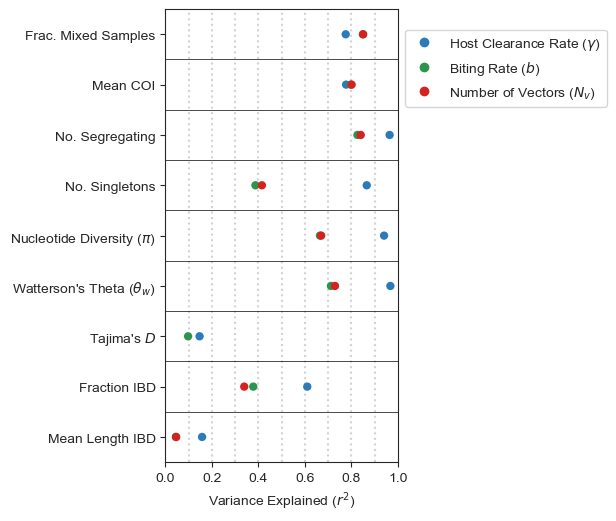

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))

ax.scatter(final_df["r2"], 
           final_df["ix"],
           color=final_df["color"],
           marker="o",
           linewidth=0)

# Limits
ax.set_ylim((-0.5, len(tight_metrics) - 0.5))
ax.set_xlim((0, 1.0))

# Ticks
ax.set_yticks(np.arange(0, len(tight_metrics)))
ax.set_yticklabels([genetic_names[m] for m in tight_metrics[::-1]])

# Lines
for i in np.arange(len(tight_metrics)):
    ax.axhline(i - 0.5, color='black', linewidth=0.5)
for x in np.arange(0, 1.0, 0.1):
    ax.axvline(x, color='darkgrey', ls='dotted', alpha=0.5, zorder=0)
    
# Labels
ax.set_xlabel("Variance Explained ($r^2$)")

# Legend
leg_handles = [mpl.lines.Line2D([0], [0], 
                                marker='o', color=sns.color_palette("Blues", 6)[4],
                                label="Host Clearance Rate ($\gamma$)", lw=0)]
leg_handles += [mpl.lines.Line2D([0], [0], 
                                marker='o', color=sns.color_palette("Greens", 6)[4],
                                label="Biting Rate ($b$)", lw=0)]
leg_handles += [mpl.lines.Line2D([0], [0], 
                                marker='o', color=sns.color_palette("Reds", 6)[4],
                                label="Number of Vectors ($N_v$)", lw=0) ]
ax.legend(handles=leg_handles, bbox_to_anchor=(1.0, 0.97))

if savefig:
    fig.savefig(os.path.join(output_dir, "sec2_cf-r2-narrow.png"), 
                bbox_inches="tight", pad_inches=0.5)
    fig.savefig(os.path.join(output_dir, "sec2_cf-r2-narrow.pdf"), 
                bbox_inches="tight", pad_inches=0.5)

## Narrow, right-side

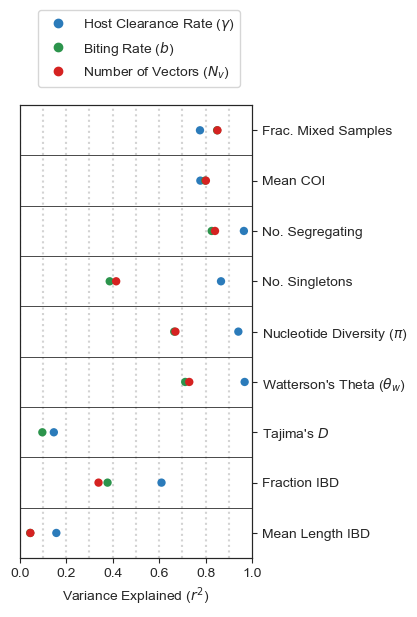

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))

ax.scatter(final_df["r2"], 
           final_df["ix"],
           color=final_df["color"],
           marker="o",
           linewidth=0)

# Limits
ax.set_ylim((-0.5, len(tight_metrics) - 0.5))
ax.set_xlim((0, 1.0))

# Ticks
ax.set_yticks([])
ax.set_yticklabels("")
axm = ax.twinx()
axm.set_ylim((-0.5, len(tight_metrics) - 0.5))
axm.set_xlim((0, 1.0))
axm.set_yticks(np.arange(0, len(tight_metrics)))
axm.set_yticklabels([genetic_names[m] for m in tight_metrics[::-1]])

# Lines
for i in np.arange(len(tight_metrics)):
    ax.axhline(i - 0.5, color='black', linewidth=0.5)
for x in np.arange(0, 1.0, 0.1):
    ax.axvline(x, color='darkgrey', ls='dotted', alpha=0.5, zorder=0)
    
# Labels
ax.set_xlabel("Variance Explained ($r^2$)")

# Legend
leg_handles = [mpl.lines.Line2D([0], [0], 
                                marker='o', color=sns.color_palette("Blues", 6)[4],
                                label="Host Clearance Rate ($\gamma$)", lw=0)]
leg_handles += [mpl.lines.Line2D([0], [0], 
                                marker='o', color=sns.color_palette("Greens", 6)[4],
                                label="Biting Rate ($b$)", lw=0)]
leg_handles += [mpl.lines.Line2D([0], [0], 
                                marker='o', color=sns.color_palette("Reds", 6)[4],
                                label="Number of Vectors ($N_v$)", lw=0) ]
ax.legend(handles=leg_handles, bbox_to_anchor=(0.05, 1.025))

if savefig:
    fig.savefig(os.path.join(output_dir, "sec2_cf-r2-narrow-rs.png"), 
                bbox_inches="tight", pad_inches=0.5)
    fig.savefig(os.path.join(output_dir, "sec2_cf-r2-narrow-rs.pdf"), 
                bbox_inches="tight", pad_inches=0.5)